In [0]:
from keras import backend as K
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization, Lambda
from keras.layers import Conv2D, MaxPooling2D, Input, SeparableConv2D, concatenate, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import np_utils

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


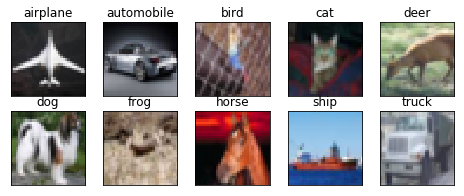

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2) 

## Functional API

In [9]:
#BLOCK 1                                                                        
#///////////////////////////////////////////////////////////////////////////
#INPUT LAYER
inputs = Input(shape=(32, 32, 3))
L1 = SeparableConv2D(32, 5, 5, border_mode='same')(inputs)                      
L1 = BatchNormalization()(L1)
L1 = Activation('relu')(L1)

#CONVOLUTION LAYER
L2 = Conv2D(64, 5, 5, border_mode='same')(L1)
L2 = BatchNormalization()(L2)
L2 = Activation('relu')(L2)

L3 = Conv2D(64, 5, 5, border_mode='same')(L2)
L3 = BatchNormalization()(L3)
L3 = Activation('relu')(L3)

L1_L3 = concatenate([L1, L3])

L4 = SeparableConv2D(128, 5, 5, border_mode='same')(L1_L3)
L4 = BatchNormalization()(L4)
L4 = Activation('relu')(L4)

L1_L4 = concatenate([L1, L4])
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

#BLOCK 2
#///////////////////////////////////////////////////////////////////////////
#TRANSITION LAYER
T1 = MaxPooling2D(pool_size=(2, 2))(L1_L4)                                 
T1 = Conv2D(64, (1, 1))(T1)
T1 = BatchNormalization()(T1)
T1 = Activation('relu')(T1)

#CONVOLUTION LAYER
L5 = SeparableConv2D(64, 3, 3, border_mode='same')(T1)
L5 = BatchNormalization()(L5)
L5 = Activation('relu')(L5)

L1_B1_B2 = Lambda(space_to_depth_x2)(L1)
L2_B1_B2 = Lambda(space_to_depth_x2)(L2)
L3_B1_B2 = Lambda(space_to_depth_x2)(L3)
L4_B1_B2 = Lambda(space_to_depth_x2)(L4)

L1_L4_L5 = concatenate([L1_B1_B2, L4_B1_B2, L5])

L6 = Conv2D(128, 5, 5, border_mode='same')(L1_L4_L5)
L6 = BatchNormalization()(L6)
L6 = Activation('relu')(L6)

L3_L4_L5_L6 = concatenate([L3_B1_B2, L4_B1_B2, L5, L6])

L7 = SeparableConv2D(256, 3, 3, border_mode='same')(L3_L4_L5_L6)
L7 = BatchNormalization()(L7)
L7 = Activation('relu')(L7)

L3_L4_L5_L6_L7 = concatenate([L3_B1_B2, L4_B1_B2, L5, L6, L7])

L8 = SeparableConv2D(512, 5, 5, border_mode='same')(L3_L4_L5_L6_L7)
L8 = BatchNormalization()(L8)
L8 = Activation('relu')(L8)

L4_L5_L7_L8 = concatenate([L4_B1_B2, L5, L7, L8])
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

#BLOCK3
#//////////////////////////////////////////////////////////////////////////////
#TRANSITION LAYER
T2 = MaxPooling2D(pool_size=(2, 2))(L4_L5_L7_L8)                                 
T2 = Conv2D(64, (1, 1))(T2)
T2 = BatchNormalization()(T2)
T2 = Activation('relu')(T2)

L1_B1_B3 = Lambda(space_to_depth_x2)(L1_B1_B2)
L2_B1_B3 = Lambda(space_to_depth_x2)(L2_B1_B2)
L3_B1_B3 = Lambda(space_to_depth_x2)(L3_B1_B2)
L4_B1_B3 = Lambda(space_to_depth_x2)(L4_B1_B2)

L5_B2_B3 = Lambda(space_to_depth_x2)(L5)
L6_B2_B3 = Lambda(space_to_depth_x2)(L6)
L7_B2_B3 = Lambda(space_to_depth_x2)(L7)

T2_L6 = concatenate([T2, L6_B2_B3])

#CONVOLUTION LAYER
L9 = Conv2D(64, 5, 5, border_mode='same')(T2_L6)
L9 = BatchNormalization()(L9)
L9 = Activation('relu')(L9)

L2_L4_L7_L9 = concatenate([L2_B1_B3, L4_B1_B3, L7_B2_B3, L9])

L10 = SeparableConv2D(128, 5, 5, border_mode='same')(L2_L4_L7_L9)
L10 = BatchNormalization()(L10)
L10 = Activation('relu')(L10)

L2_L3_L5_L9_L10 = concatenate([L2_B1_B3, L3_B1_B3, L5_B2_B3, L9, L10])

L11 = Conv2D(256, 3, 3, border_mode='same')(L2_L3_L5_L9_L10)
L11 = BatchNormalization()(L11)
L11 = Activation('relu')(L11)

L1_L3_L4_L5_L7_L10_L11 = concatenate([L1_B1_B3, L3_B1_B3, L4_B1_B3, L5_B2_B3, L7_B2_B3, L10, L11])

L12 = SeparableConv2D(512, 5, 5, border_mode='same')(L1_L3_L4_L5_L7_L10_L11)
L12 = BatchNormalization()(L12)
L12 = Activation('relu')(L12)

L4_L7_L10_L12 = concatenate([L4_B1_B3, L7_B2_B3, L10, L12])
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

#OUTPUT LAYER
O = Conv2D(10, 1, activation='relu')(L4_L7_L10_L12)
O = GlobalAveragePooling2D()(O)
predictions = Activation('softmax')(O)
model = Model(inputs=inputs, outputs=predictions)



W0620 21:54:52.461877 139847575295872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 21:54:52.494693 139847575295872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), padding="same")`
  
W0620 21:54:52.503632 139847575295872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 21:54:52.548949 139847575295872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-pa

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0620 21:54:56.887467 139847575295872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
W0620 21:54:58.976978 139847575295872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
391/391 [==============================] - 164s 418ms/step - loss: 1.4243 - acc: 0.5178 - val_loss: 1.6429 - val_acc: 0.5027
Epoch 2/100
391/391 [==============================] - 151s 386ms/step - loss: 0.9875 - acc: 0.6733 - val_loss: 1.1635 - val_acc: 0.6343
Epoch 3/100
391/391 [==============================] - 150s 384ms/step - loss: 0.8088 - acc: 0.7323 - val_loss: 1.2386 - val_acc: 0.6103
Epoch 4/100
391/391 [==============================] - 150s 384ms/step - loss: 0.6869 - acc: 0.7683 - val_loss: 1.0890 - val_acc: 0.6688
Epoch 5/100
391/391 [==============================] - 150s 383ms/step - loss: 0.5854 - acc: 0.8003 - val_loss: 1.1242 - val_acc: 0.6680
Epoch 6/100
391/391 [==============================] - 150s 384ms/step - loss: 0.4959 - acc: 0.8266 - val_loss: 1.3960 - val_acc: 0.6320
Epoch 7/100
391/391 [==============================] - 150s 384ms/step - loss: 0.4246 - acc: 0.8482 - val_loss: 1.0265 - val_acc: 0.6739
Epoch 8/100
391/391 [====================

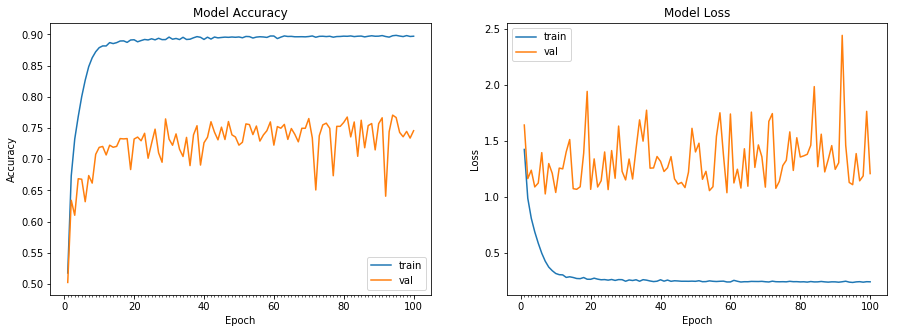

Accuracy on test data is: 35.89


In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=True)
datagen.fit(train_features)
training_set= datagen.flow(train_features, train_labels, batch_size=128)
test_set= datagen.flow(test_features, test_labels, batch_size=128)

# train the model
start = time.time()
# Train the model

model_info = model.fit_generator(training_set, steps_per_epoch=len(training_set), epochs=100, validation_data = test_set, validation_steps = len(test_set))

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))